In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Mounted at /content/drive
Num GPUs Available:  1


In [ ]:
# set up constants

BASE_GENRES = [
    "genre_blues",
    "genre_classical",
    "genre_country",
    "genre_disco",
    "genre_hiphop",
    "genre_jazz",
    "genre_metal",
    "genre_pop",
    "genre_reggae",
    "genre_rock"
]

STRATIFY = ['stratify']

KEY = ['metadata_path']

In [ ]:
# load base dataframe

import pandas as pd

filepath = "/content/drive/MyDrive/w207/mids_w207_music_genre/member_workspaces/lawrence/mtg_jamendo_genre_features_base.feather"
df_base = pd.read_feather(filepath)

In [ ]:
# split base data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np


# get features
FEATURES = [c for c in df_base.columns if c.startswith('mfcc_cov')]
X = df_base[FEATURES]

# get targets
enc = LabelEncoder()
y = enc.fit_transform(df_base[STRATIFY].values.reshape(-1))

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
  
print(F"X_train: {X_train.shape}")
print(F"X_test:  {X_test.shape}")

# scale
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train, y_train)
# X_test = scaler.transform(X_test)

# # scale X_train
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)
X_train = (X_train - X_train_mean) / X_train_std

# # scale X_test
X_test = (X_test - X_train_mean) / X_train_std

print(F"X_train: {X_train.shape}")
print(F"X_test:  {X_test.shape}")

X_train: (17080, 169)
X_test:  (4271, 169)
X_train: (17080, 169)
X_test:  (4271, 169)


## Experiment \#1: Shallow network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Output (Dense)              (None, 10)                655690    
                                                                 
Total params: 655,690
Trainable params: 655,690
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
19/19 [==============================] - 3s 23ms/step - loss: 136504.4219 - accuracy: 0.1050 - val_loss: 56078.2656 - val_accuracy: 0.1700
Epoch 2/20
19/19 [==============================] - 0s 9ms/step - loss: 123245.7734 - accuracy: 0.1367 - val_loss: 181624.5938 - val_accuracy: 0.1500
Epoch 3/20
19/19 [==============================] - 0s 8ms/step - loss: 100234.8125 - accuracy: 0.1500 - val_loss: 78239.7266 - val_accuracy: 0.1650
Epoch 4/20
19/19 [==============================] - 0s 9ms/step - loss: 95743.0781 - accuracy: 0.1717 - val_loss: 141735.3750 - v

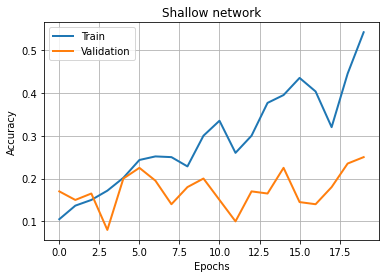

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
model = tf.keras.Sequential()
model.add(
    tf.keras.Input(shape=(65568,), name='Input'))
model.add(
    tf.keras.layers.Dense(units=10, activation='softmax', name='Output'))
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.SGD(),
    metrics=['accuracy'])
model.summary()

# fit model
history = model.fit(x=X_train, y=y_train, validation_split=0.25, epochs=20)

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("Shallow network")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# get test accuracy
y_pred = np.argmax(model.predict(x=X_test), axis=1)
test_accuracy = accuracy_score(y_test, y_pred)
print(F"Test accuracy: {test_accuracy}")

## Experiment \#2: Deep network

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# clear session + set random seed
tf.keras.backend.clear_session()
tf.random.set_seed(10)

# build model
model = tf.keras.Sequential()
model.add(
    tf.keras.Input(shape=(169,), name='Input'))
# model.add(
#     tf.keras.layers.Dense(units=256, activation='relu', name='Layer_1'))
# model.add(
#     tf.keras.layers.Dense(units=128, activation='relu', name='Layer_2'))
# model.add(
#     tf.keras.layers.Dense(units=64, activation='relu', name='Layer_3'))
model.add(
    tf.keras.layers.Dense(units=32, activation='leaky_relu', name='Layer_4'))
# model.add(
#     tf.keras.layers.Dense(units=16, activation='relu', name='Layer_5'))
model.add(
    tf.keras.layers.Dense(units=10, activation='softmax', name='Output'))

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# history = model.fit(x=X_train, y=y_train, validation_split=0.25, epochs=20, callbacks=[es])
history = model.fit(x=X_train, y=y_train, validation_split=0.25, epochs=100)

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.set_title("FFNN with 1 layer")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

# get test accuracy
y_pred = np.argmax(model.predict(x=X_test), axis=1)
train_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]
test_accuracy = accuracy_score(y_test, y_pred)
print(F"Train accuracy: {train_accuracy}")
print(F"Validation accuracy: {validation_accuracy}")
print(F"Test accuracy: {test_accuracy}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_4 (Dense)             (None, 32)                5440      
                                                                 
 Output (Dense)              (None, 10)                330       
                                                                 
Total params: 5,770
Trainable params: 5,770
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
401/401 [==============================] - 2s 4ms/step - loss: 1.6085 - accuracy: 0.4555 - val_loss: 1.4123 - val_accuracy: 0.5185
Epoch 2/100
401/401 [==============================] - 1s 3ms/step - loss: 1.3424 - accuracy: 0.5406 - val_loss: 1.3374 - val_accuracy: 0.5429
Epoch 3/100
401/401 [==============================] - 1s 3ms/step - loss: 1.2736 - accuracy: 0.5602 - val_loss: 1.3137 - val_accuracy: 0.5485
Epoch 4/100
401/401 [

KeyboardInterrupt: ignored

# Experiment \#2: CNNs

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 13, 13, 1)         0         
                                                                 
 locally_connected2d (Locall  (None, 13, 13, 256)      86528     
 yConnected2D)                                                   
                                                                 
 flatten (Flatten)           (None, 43264)             0         
                                                                 
 dense (Dense)               (None, 10)                432650    
                                                                 
Total params: 519,178
Trainable params: 519,178
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
401/401 [==============================] - 5s 9ms/step - loss: 1.3960 - accuracy: 0.5165 - val_loss: 1.2

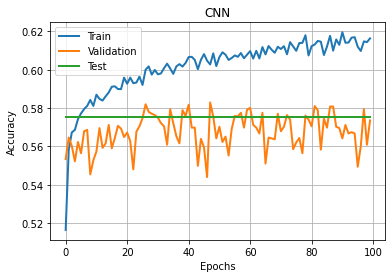

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# clear session + set random seed
tf.keras.backend.clear_session()
# tf.random.set_seed(10)

# build model
model = tf.keras.Sequential()
model.add(
    tf.keras.Input(shape=(169,)))
model.add(
    tf.keras.layers.Reshape((13, 13, 1)))
model.add(
    tf.keras.layers.LocallyConnected2D(filters=256, kernel_size=(1,1), activation='leaky_relu'))
# model.add(
#     tf.keras.layers.Dropout(0.2))
# model.add(
#     tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), activation='relu'))
# model.add(
#     tf.keras.layers.Dropout(0.2))
# model.add(
#     tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), activation='relu'))
# model.add(
#     tf.keras.layers.Conv2D(filters=32, kernel_size=(1,1), activation='relu'))
# model.add(
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# model.add(
#     tf.keras.layers.Conv2D(filters=128, kernel_size=(1,1), activation='relu'))
# model.add(
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# model.add(
#     tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
# model.add(
#     tf.keras.layers.Dropout(0.2))
# model.add(
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# model.add(
#     tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
# model.add(
#     tf.keras.layers.Dropout(0.2))
# model.add(
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# model.add(
#     tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
# model.add(
#     tf.keras.layers.Dropout(0.2))
# model.add(
#     tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(
    tf.keras.layers.Flatten())
model.add(
    tf.keras.layers.Dense(units=10, activation='softmax'))

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'])
model.summary()

# fit model
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
# history = model.fit(x=X_train, y=y_train, validation_split=0.25, epochs=1000, callbacks=[es])
history = model.fit(x=X_train, y=y_train, validation_split=0.25, epochs=100)

# get test accuracy
y_pred = np.argmax(model.predict(x=X_test), axis=1)
train_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]
test_accuracy = accuracy_score(y_test, y_pred)
print(F"Train accuracy: {train_accuracy}")
print(F"Validation accuracy: {validation_accuracy}")
print(F"Test accuracy: {test_accuracy}")

# graph train and validation accuracies over epochs
fig, ax = plt.subplots()
ax.plot(history.history['accuracy'], linewidth=2.0, label='Train')
ax.plot(history.history['val_accuracy'], linewidth=2.0, label='Validation')
ax.plot(np.ones((len(history.history['accuracy']),))*test_accuracy, linewidth=2.0, label='Test')
ax.set_title("CNN")
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()